# Linear Regressions Models for Exchange Rate Regimes

The Chinese Yuan was pegged to the US Dollar prior to July 2005. Then, China announced that the exchange rate would be set with reference to a basket of other currencies, allowing for a movement of up to 0.3% movement within any given day. The actual currencies and their basket weights are unannounced by China. From an empirical standpoint, there are several important questions:

* For any given period, what is the implicit reference basket for the Chinese currency?
* Has the reference basket changed over time?
* Has the Chinese currency depreciated with respect to the dollar? If so, how much and when?

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats

In [4]:
# down the data
symbols = ["DEXCHUS", "DEXJPUS", "DEXKOUS", "DEXMAUS",
           "DEXUSEU", "DEXUSUK", "DEXTHUS", "DEXSZUS"]
start_date = "1999-01-01"
end_date = "2018-12-31"

In [12]:
def get_exchange_data(symbols, start_date, end_date):
    data = pdr.fred.FredReader(symbols, start_date, end_date).read().dropna()
    data = data.rename_axis(None)
    return data

In [14]:
fxrates = get_exchange_data(symbols, start_date, end_date)

In [15]:
fxrates.head()

,DEXCHUS,DEXJPUS,DEXKOUS,DEXMAUS,DEXUSEU,DEXUSUK,DEXTHUS,DEXSZUS
1999-01-04,8.2793,112.15,1187.5,3.8,1.1812,1.6581,36.20,1.3666
1999-01-05,8.2795,111.15,1166.0,3.8,1.1760,1.6566,36.18,1.3694
1999-01-06,8.2795,112.78,1160.0,3.8,1.1636,1.6547,36.50,1.3852
1999-01-07,8.2798,111.69,1151.0,3.8,1.1672,1.6495,36.30,1.3863
1999-01-08,8.2796,111.52,1174.0,3.8,1.1554,1.6405,36.45,1.3970


* DEXCHUS China / U.S. Foreign Exchange Rate Chinese Yuan to 1 U.S.
* DEXJPUS Japan / U.S. Foreign Exchange Rate Japanese Yen to 1 U.S. 
* DEXKOUS South Korea / U.S. Foreign Exchange Rate South Korean Won to 1 U.S. 
* DEXMAUS Malaysia / U.S. Foreign Exchange Rate Malaysian Ringgit to 1 U.S. 
* DEXUSEU U.S. / Euro Foreign Exchange Rate U.S.  to 1 Euro
* DEXUSUK U.S. / U.K. Foreign Exchange Rate U.S.  to 1 British Pound
* DEXTHUS Thailand / U.S. Foreign Exchange Rate Thai Baht to 1 U.S.
* DEXSZUS Switzerland / U.S. Foreign Exchange Rate Swiss Francs to 1 U.S. 

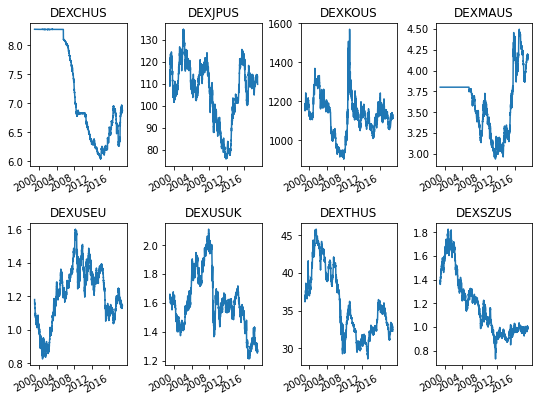

In [37]:
fig, axes = plt.subplots(2, 4, figsize=(9, 7))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
axes = axes.flatten()
for n, ax in enumerate(axes):
    fxrates.iloc[:, n].plot(ax=ax)
    ax.set_title(fxrates.columns[n])

We re-express the dollar-based exchange rates using another currency, the Swiss Franc. This allows currency moves of the dollar to be be used to explain moves in the Yuan. The choice of Swiss Franc is consistent with evaluations with respect to a stable, developed-market currency. 

In [105]:
# transform the dataset
def transform_dataset(fxrates):
    us_base = [fx for fx in fxrates.columns if fx.endswith('US') and fx!='DEXSZUS']
    not_usbase = [fx for fx in fxrates.columns if (not fx.endswith('US')) and fx!='DEXSZUS']
    sub1 = fxrates[us_base]
    sub2 = fxrates[not_usbase]
    sub1 = np.divide(sub1, fxrates['DEXSZUS'].values.reshape((-1, 1)))
    sub1.columns = [fx[3:5]+'_SFR' for fx in fxrates.columns if fx.endswith('US') and fx!='DEXSZUS']
    sub2 = 1/(np.multiply(sub2, fxrates['DEXSZUS'].values.reshape((-1, 1))))
    sub2.columns = [fx[5:7]+'_SFR' for fx in fxrates.columns if (not fx.endswith('US')) and fx!='DEXSZUS']
    sub3 = 1/fxrates['DEXSZUS']  # it is a series
    sub3.name = 'US_SFR'
    data = pd.concat([sub1, sub2, sub3], axis=1)
    return data

In [110]:
# for exchange rate with US in base, divide DEXSZUS
dataset = transform_dataset(fxrates)

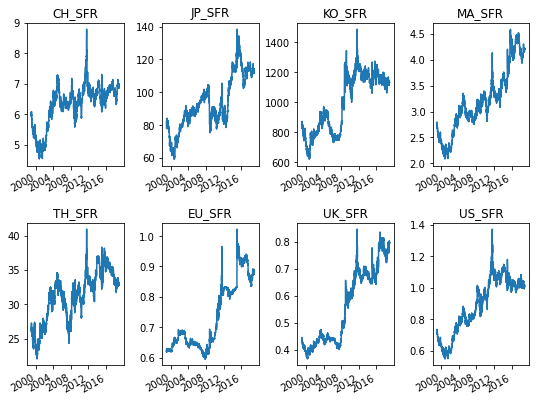

In [111]:
# plot the transformmed dataset again
fig, axes = plt.subplots(2, 4, figsize=(9, 7))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
axes = axes.flatten()
for n, ax in enumerate(axes):
    dataset.iloc[:, n].plot(ax=ax)
    ax.set_title(dataset.columns[n])

In [112]:
dataset.head()

,CH_SFR,JP_SFR,KO_SFR,MA_SFR,TH_SFR,EU_SFR,UK_SFR,US_SFR
1999-01-04,6.058320,82.064979,868.944827,2.780623,26.489097,0.619491,0.441314,0.731743
1999-01-05,6.046079,81.166934,851.467796,2.774938,26.420330,0.620958,0.440811,0.730247
1999-01-06,5.977115,81.417846,837.424199,2.743286,26.349986,0.620417,0.436283,0.721917
1999-01-07,5.972589,80.566977,830.267619,2.741109,26.184808,0.618013,0.437311,0.721345
1999-01-08,5.926700,79.828203,840.372226,2.720115,26.091625,0.619543,0.436342,0.715820


In [122]:
# calculate the daily log return
daily_logreturn = np.log(dataset).diff().dropna()

<AxesSubplot:>

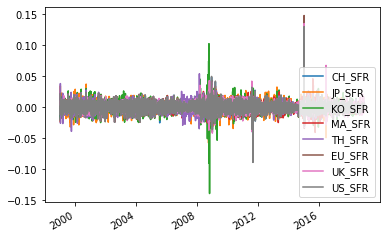

In [124]:
daily_logreturn.plot()

In [129]:
# run the regression for the period prior to July 2005
period1 = daily_logreturn[daily_logreturn.index < '2005-08-01']
period1.tail()

,CH_SFR,JP_SFR,KO_SFR,MA_SFR,TH_SFR,EU_SFR,UK_SFR,US_SFR
2005-07-25,-0.001253,0.004401,0.004305,-0.006914,-0.001564,0.000991,-0.003490,-0.001080
2005-07-26,-0.003210,0.003108,0.002122,-0.005764,0.002795,0.000672,-0.000940,-0.003234
2005-07-27,0.001973,0.001616,0.001130,0.001483,0.002817,-0.001793,0.000296,0.001616
2005-07-28,0.007604,0.008552,0.006932,0.007929,0.011553,0.002155,0.001965,0.008196
2005-07-29,0.000481,-0.000025,-0.000392,0.001043,-0.002340,0.000117,-0.001841,0.000777


In [132]:
p1_model = smf.ols('CH_SFR ~ US_SFR + JP_SFR + EU_SFR + UK_SFR', data=period1).fit()
p1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 CH_SFR   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 7.521e+04
Date:                Wed, 31 Mar 2021   Prob (F-statistic):               0.00
Time:                        15:19:20   Log-Likelihood:                 10220.
No. Observations:                1654   AIC:                        -2.043e+04
Df Residuals:                    1649   BIC:                        -2.040e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.293e-05   1.24e-05     -1.047      0.295   -3.72e-05    1.13e-05
US_SFR         1.0020      0.003    368.482      0.000       0.997       1.007
JP_SFR        -0.0010      0.002     -0.502      0.616      -0.005       0.003
EU_SFR         0.0039      0.006      0.664      0.507      -0.008       0.015
UK_SFR        -0.0010      0.003     -0.299      0.765      -0.008       0.006
==============================================================================
Omnibus:                     4853.583   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        171156223.119
Skew:                         -39.237   Prob(JB):                         0.00
Kurtosis:                    1576.965   Cond. No.                         479.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The regression fit identifies the pegging of the Yuan to the US Dollar. The R-Squared is nearly 1.0.

In [143]:
period2 = daily_logreturn[daily_logreturn.index <= '2005-12-31']
period2 = period2[period2.index >= '2005-07-01']
period2.tail()

,CH_SFR,JP_SFR,KO_SFR,MA_SFR,TH_SFR,EU_SFR,UK_SFR,US_SFR
2005-12-23,-0.002981,-0.004279,-0.005333,-0.002767,-0.004042,-0.000629,0.001155,-0.002820
2005-12-27,-0.000623,0.005759,-0.001436,-0.000205,0.001315,-0.000068,0.000887,-0.000152
2005-12-28,0.001002,0.005677,0.001829,0.000990,0.000745,-0.000612,0.005739,0.000990
2005-12-29,-0.001264,0.000973,-0.005072,-0.000933,0.001131,0.001379,-0.003096,-0.001066
2005-12-30,-0.000467,-0.000211,0.000610,-0.000645,-0.000868,-0.000043,0.003858,-0.000380


In [144]:
p2_model = smf.ols('CH_SFR ~ US_SFR + JP_SFR + EU_SFR + UK_SFR + KO_SFR + MA_SFR + TH_SFR', data=period2).fit()
p2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 CH_SFR   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     311.4
Date:                Wed, 31 Mar 2021   Prob (F-statistic):           1.73e-72
Time:                        15:26:59   Log-Likelihood:                 637.74
No. Observations:                 125   AIC:                            -1259.
Df Residuals:                     117   BIC:                            -1237.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0001      0.000     -0.867      0.387      -0.000       0.000
US_SFR         0.1949      0.153      1.275      0.205      -0.108       0.498
JP_SFR        -0.0083      0.038     -0.216      0.829      -0.084       0.067
EU_SFR         0.0698      0.094      0.744      0.458      -0.116       0.255
UK_SFR        -0.0255      0.046     -0.560      0.577      -0.116       0.065
KO_SFR         0.1786      0.036      4.921      0.000       0.107       0.250
MA_SFR         0.7527      0.147      5.116      0.000       0.461       1.044
TH_SFR        -0.0694      0.061     -1.138      0.258      -0.190       0.051
==============================================================================
Omnibus:                      186.710   Durbin-Watson:                   2.361
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13871.533
Skew:                          -5.732   Prob(JB):                         0.00
Kurtosis:                      53.318   Cond. No.                     1.54e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

During this six-month period, there is evidence of the Yuan departing from a US Dollar peg. The exchange rates with the statsitically significant regression parameters are for the Korean Won (WON SFR) and the Malaysian Ringgit (MYR SFR).

In [146]:
period3 = daily_logreturn[daily_logreturn.index <= '2013-12-31']
period3 = period3[period3.index >= '2006-01-01']
period3.head()

,CH_SFR,JP_SFR,KO_SFR,MA_SFR,TH_SFR,EU_SFR,UK_SFR,US_SFR
2006-01-03,0.016101,0.002951,0.009046,0.016366,0.010474,0.004515,0.003612,0.016101
2006-01-04,0.010645,0.010388,0.005848,0.009269,0.002516,0.001423,0.000129,0.010645
2006-01-05,0.002127,-0.000589,-0.001490,0.000064,-0.001789,0.001598,0.003676,0.002425
2006-01-06,0.005705,-0.007217,0.000849,0.003125,-0.004848,0.002014,-0.001539,0.005890
2006-01-09,-0.007743,-0.005935,-0.019769,-0.009634,-0.010282,-0.000829,-0.004825,-0.007768


In [147]:
p3_model = smf.ols('CH_SFR ~ US_SFR + JP_SFR + EU_SFR + UK_SFR + KO_SFR + MA_SFR + TH_SFR', data=period3).fit()
p3_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 CH_SFR   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 1.234e+04
Date:                Wed, 31 Mar 2021   Prob (F-statistic):               0.00
Time:                        15:27:46   Log-Likelihood:                 10866.
No. Observations:                2012   AIC:                        -2.172e+04
Df Residuals:                    2004   BIC:                        -2.167e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0001   2.44e-05     -5.669      0.000      -0.000   -9.06e-05
US_SFR         0.9339      0.008    115.352      0.000       0.918       0.950
JP_SFR         0.0010      0.004      0.254      0.800      -0.007       0.009
EU_SFR         0.0147      0.007      2.081      0.038       0.001       0.029
UK_SFR         0.0051      0.005      1.008      0.314      -0.005       0.015
KO_SFR        -0.0095      0.003     -2.958      0.003      -0.016      -0.003
MA_SFR         0.0563      0.007      8.040      0.000       0.043       0.070
TH_SFR         0.0064      0.006      1.113      0.266      -0.005       0.018
==============================================================================
Omnibus:                      465.420   Durbin-Watson:                   2.392
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22024.903
Skew:                          -0.097   Prob(JB):                         0.00
Kurtosis:                      19.208   Cond. No.                         393.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

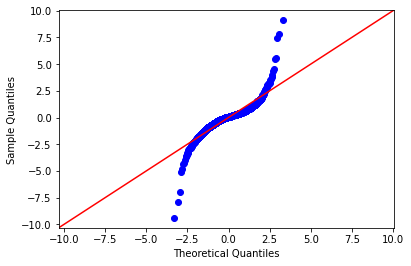

In [158]:
fig = sm.qqplot(p3_model.resid, fit=True, line='45')
# fig.axes[0].set_xlim(-3, 3)

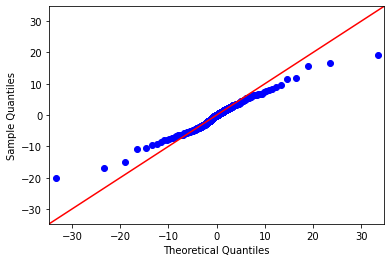

In [149]:
fig = sm.qqplot(p3_model.resid, stats.t, fit=True, line="45")

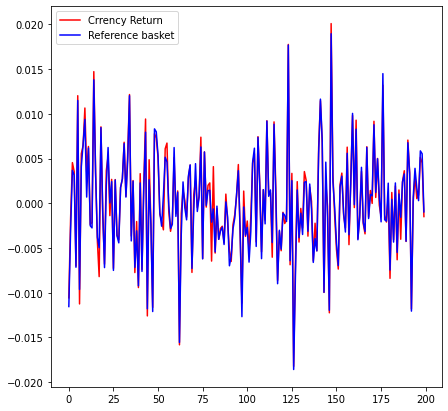

In [181]:
# check wehter the reference basket tracks the Yuan well or not
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
axes.plot(period3['CH_SFR'][-500:-300].values, color='r', label='Crrency Return')
axes.plot(p3_model.predict()[-500:-300], color='b', label='Reference basket')
axes.legend()

Note how closely the reference basket tracks the Yuan. This is to be expected given the high R−squared of the regression. 